In [4]:
## GO DOWN TO THE BOTTOM OF THIS PAGE

from astroduet.bbmag import bb_abmag, bb_abmag_fluence
import astropy.units as ur



In [5]:
bb_abmag(swiftmag=25*ur.ABmag, diag=True, bandone=[120., 180]*ur.nm, bandtwo=[180, 280]*ur.nm)


Compute ABmags in TD bands for blackbody
Blackbody temperature: 20000.0 K
Reference UVW2-band magnitude: 25.0 mag(AB)
Band one: [120. 180.] nm
Band two: [180. 280.] nm
Distance: 10.0 pc
Flux density band one: 0.0004389061843634471 erg / (Angstrom cm2 s)
Flux density band two: 0.00029752710160622844 erg / (Angstrom cm2 s)
Flux density Swift: 0.0003556698779755909 erg / (Angstrom cm2 s)
Distance modulus: 0.0 mag
Raw ABmag band one: -9.894333788635599 mag(AB)
Raw ABmag band two: -10.400403751643468 mag(AB)
Raw ABmag Swift: -10.323580926623904 mag(AB)
Offset from Swift band: 35.323580926623904 mag
ABmag band one: 25.429247137988305 mag(AB)
ABmag band two: 24.923177174980438 mag(AB)



(<Magnitude 25.42924714 mag(AB)>, <Magnitude 24.92317717 mag(AB)>)

In [6]:
import astropy.constants as cr
from astropy.modeling import models
from astropy.modeling.blackbody import FLAM
import numpy as np

bbtemp = 20e3*ur.K
umag = 22*ur.ABmag
swiftmag = 22*ur.ABmag
dist = 10*ur.pc
ref = 'swift'
dist0 = 10*ur.pc
bolflux =1.*ur.erg/(ur.cm**2 * ur.s)

bandu = [340,380]*ur.nm # For comparison purposes
bandsw = [172.53,233.57]*ur.nm # Swift UVW2 effective band (lambda_eff +/- 0.5 width_eff)

wav = np.arange(1000,9000) * ur.AA # Wavelength scale in 1 Angstrom steps
bb = models.BlackBody1D(temperature=bbtemp,bolometric_flux=bolflux) # Load the blackbody model
flux = bb(wav).to(FLAM, ur.spectral_density(wav))

# Get Swift reference AB mag
fluxden_sw = np.mean(flux[(wav >= bandsw[0].to(ur.AA)) & (wav <= bandsw[1].to(ur.AA))])
magsw = fluxden_sw.to(ur.ABmag, equivalencies=ur.spectral_density(np.mean(bandsw)))

# Conver to flux AB mags across the band.
flux_ab = flux.to(ur.ABmag, equivalencies = ur.spectral_density(wav))

# Distance modulus
distmod = (5*np.log10(dist/dist0)).value*ur.mag

# Set up input:
magoff = swiftmag - magsw

# Apply the distance modulus and the Swift reference offset
if (bolflux == 1.*ur.erg/(ur.cm**2 * ur.s)):
    flux_mag = flux_ab + magoff + distmod
else:
    flux_mag = flux_ab

# Convert back to flux
flux_conv = flux_mag.to(FLAM, equivalencies=ur.spectral_density(wav))
dw = 1*ur.AA
ph_energy = (cr.h.cgs * cr.c.cgs / wav.cgs) / ur.ph

# Convert to photon flux.
ph_flux = flux_conv * dw / ph_energy

# # Apply filters, QE, etc.
# band1_fluence = duet.apply_filters(wav, ph_flux, diag=diag, **kwargs).sum()
# band2_fluence = duet.apply_filters(wav, ph_flux, band = 2, diag=diag, **kwargs).sum()


In [7]:
import matplotlib.pyplot as plt

3.894961468778157e-06 ph / (cm2 s)
3.945512077422105e-06 ph / (cm2 s)


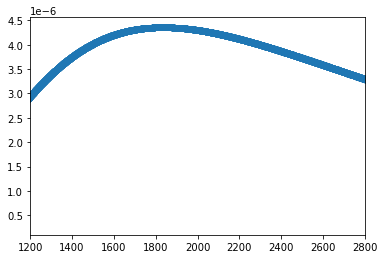

In [8]:
ax = plt.figure().subplots()
ax.scatter(wav, ph_flux)
ax.set_xlim(1200, 2800)

mean_fuv = ph_flux[(wav>1200*ur.AA)&(wav<1800*ur.AA)].mean()
mean_nuv = ph_flux[(wav>1800*ur.AA)&(wav<2800*ur.AA)].mean()


print(mean_fuv)
print(mean_nuv)


In [9]:
# About 3e-6 per A. So for 60 A effective width
dw_nuv = 100.
est_nuv = mean_nuv *dw_nuv

dw_fuv = 60.
est_fuv = dw_fuv * mean_fuv
print(est_nuv) # DUET about 4.1e-4, so close enough
print(est_fuv)

0.00039455120774221046 ph / (cm2 s)
0.00023369768812668941 ph / (cm2 s)


In [10]:
epd = 50 * ur.cm
area = np.pi*(epd*0.5)**2

exposure = 600*ur.s

refl_eff = 0.9
mirrors = 3.0
dichroic = 0.7
qe_fuv = 0.4
qe_nuv = 0.6


In [11]:
# FUV estimate

fuv_fluence = est_fuv * (refl_eff**mirrors) * dichroic * qe_fuv
fuv_rate = fuv_fluence * area
fuv_cts = fuv_rate * exposure


print(fuv_fluence)
print(fuv_rate)
print(fuv_cts)


4.770237210041985e-05 ph / (cm2 s)
0.09366338859342857 ph / s
56.19803315605714 ph


In [14]:
# NUV estimate
mirrors = 4
nuv_fluence = est_nuv * (refl_eff**mirrors) * dichroic * qe_nuv
nuv_rate = nuv_fluence * area
nuv_cts = nuv_rate * exposure


print(nuv_fluence)
print(nuv_rate)
print(nuv_cts)

0.00010872331990785897 ph / (cm2 s)
0.21347773943526416 ph / s
128.0866436611585 ph


In [23]:
from astroduet.duet_sensitivity import src_rate


Source Computation Integrating over PSF
Telescope Diameter: 50.0 cm
Fλ 7.667224588696511e-17 erg / (Angstrom cm2 s)
ReceivedPower: 56.377904744034566 eV / s
Photons per second:  6.820777017130489 1 / s
Photons per second per cm2:  0.0034737932096125137 1 / (cm2 s)
Fλ ABmag 22.0 mag(AB)
Eff λ 150.0 nm
Bandpass: 60.0 nm

6.820777017130489 1 / s


In [55]:
refl_eff = 0.8
mirrors = 3.0
dichroic = 0.4
qe_fuv = 0.4
qe_nuv = 0.6
exp = 300*ur.s


rate, rate_e = src_rate(diameter=50*ur.cm, band= [120, 180]*ur.nm, ABmag=25*ur.ABmag)
eff_rate = rate * qe_fuv * (refl_eff**mirrors)*dichroic
print(eff_rate)
print(eff_rate * exp)


rate, rate_e = src_rate(diameter=50*ur.cm, band= [180, 280]*ur.nm, ABmag=25*ur.ABmag)
eff_rate = rate * qe_nuv * (refl_eff**mirrors)*dichroic
print(eff_rate)
print(eff_rate * exp)





0.03525524974813344 1 / s
10.576574924440031
0.05748138545891323 1 / s
17.24441563767397


In [ ]:
#